In [5]:
# Import des modules

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
import numpy as np
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#Dataset
import pandas as pd
# Option d'affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

#Graphique
import matplotlib.pyplot as plt

In [6]:
# Chargement du dataset contenant les features
building_consumption = pd.read_csv("building_features.csv")
building_cons=building_consumption.copy()

In [7]:
# Séparation dataframe feature/variable cible
X = building_cons.drop(columns=['SiteEnergyUseWN(kBtu)'])
y = building_cons['SiteEnergyUseWN(kBtu)']

In [8]:
# Encodage et scaling sur les colonnes suivantes:

# Colonnes à encoder
cat_cols = ["PrimaryPropertyType", "Neighborhood"]

# Colonnes à scaler
num_cols = ["PropertyGFABuilding(s)", "BuildingAge"]

# Définition de notre preprocess utilisé pour tout les modèles
# ColumnTransformer renvoie une matrice combinée après application de l'encodage
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_cols),# Applique le OneHotEncoder sur cat_cols
        ("num", StandardScaler(), num_cols) # Applique le StandardScaler sur num_cols
    ],
    remainder="passthrough"
)

In [9]:
# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=808
)

In [10]:
# Création du pipeline avec DummyRegressor
model = Pipeline([
    ("preprocess", preprocess),
    ("dum", DummyRegressor())
])

In [11]:
# Entraînement du model de DummyRegressor
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('dum', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
# Prédictions Dummy Regressor en utilisant un train_test_split classique
y_pred = model.predict(X_test)

# Metriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('RMSE:',rmse)
print('MAE:',mae)
print('R²:',r2)

RMSE: 2321015.91002999
MAE: 1518959.0446810592
R²: 0.5318527429809585


In [12]:
# Définition de la fonction de modélisation utilisant cross_validate, avec scaling de y
def modelisation(mod, preprocessing):
    
    # Création du pipeline avec model choisi, en appliquant un StandardScaler sur la variable cible
    model = Pipeline([
    ("preprocess", preprocess),
    ("reg", TransformedTargetRegressor(
        regressor=mod,
        transformer=StandardScaler()
    ))
    ])
    
    # Entraînement du model de choisi
    model.fit(X_train, y_train)
    
    # Définition des variables de scores pour le cross_validate
    scoring = {
        'RMSE': make_scorer(mean_squared_error),
        'MAE': make_scorer(mean_absolute_error),
        'R2': 'r2'  # R² peut être passé directement comme string
    }
    
    # Appliquer la cross-validation
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)
    
    # Afficher les résultats
    print("RMSE moyen :", np.mean(np.sqrt(cv_results['test_RMSE'])))
    print("MAE moyen  :", np.mean(cv_results['test_MAE']))
    print("R² moyen   :", np.mean(cv_results['test_R2']))

    return model

In [62]:
# Modélisation Dummy
modelisation(DummyRegressor(),preprocess)

RMSE moyen : 3360022.948835445
MAE moyen  : 2682300.78043665
R² moyen   : -0.3410006550740899


,steps,"[('preprocess', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [64]:
# Modélisation Régression
modelReg=modelisation(LinearRegression(), preprocess)

RMSE moyen : 2092501.8415469578
MAE moyen  : 1495880.774504574
R² moyen   : 0.4813977034240315


In [66]:
# Modélisation SVR
modelSVR=modelisation(SVR(), preprocess)

RMSE moyen : 2116016.287640462
MAE moyen  : 1421371.135056868
R² moyen   : 0.47321148262007073


In [13]:
# Modélisation RandomForest
modelForest=modelisation(RandomForestRegressor(), preprocess)

RMSE moyen : 2119782.2366456413
MAE moyen  : 1455299.9691542964
R² moyen   : 0.46707820160620284


In [79]:
# GridSearchCV sur SVR

#Définition des Hyperparametres à tester (160 combinaisons)
param_grid_svr = {
    'reg__regressor__C': [0.1, 1, 10, 50, 100],        
    'reg__regressor__epsilon': [0.01, 0.05, 0.1, 0.2],
    'reg__regressor__gamma': ['scale', 'auto'],       
    'reg__regressor__kernel': ['rbf', 'poly']         
}

grid_svr = GridSearchCV(
    estimator=modelSVR,
    param_grid=param_grid_svr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_svr.fit(X, y)

print(grid_svr.best_params_)
print(grid_svr.best_score_)

{'reg__regressor__C': 10, 'reg__regressor__epsilon': 0.2, 'reg__regressor__gamma': 'auto', 'reg__regressor__kernel': 'rbf'}
-2015850.451897132


In [80]:
# Test du model SVR optimisé sur les données réelles
svr_best = grid_svr.best_estimator_
y_pred_svr = svr_best.predict(X_test)

rmse_svr_test = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr_test = r2_score(y_test, y_pred_svr)
print("RMSE :", rmse_svr_test)
print("R² :", r2_svr_test)

RMSE : 1970005.7253329442
R² : 0.6627428040442247


In [81]:
# GridSearchCV sur RandomForest

#Définition des Hyperparametres à tester (216 combinaisons)
param_grid_rf = {
    'reg__regressor__n_estimators': [200, 500, 800],   # 3
    'reg__regressor__max_depth': [None, 10, 20, 30],   # 4
    'reg__regressor__min_samples_split': [2, 5, 10],  # 3
    'reg__regressor__min_samples_leaf': [1, 2, 5],    # 3
    'reg__regressor__max_features': ['sqrt', 0.5]     # 2
}
grid_forest = GridSearchCV(
    estimator=modelForest,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_forest.fit(X, y)

print(grid_forest.best_params_)
print(grid_forest.best_score_)

{'reg__regressor__max_depth': 20, 'reg__regressor__max_features': 0.5, 'reg__regressor__min_samples_leaf': 1, 'reg__regressor__min_samples_split': 10, 'reg__regressor__n_estimators': 200}
-2039516.9782671593


In [19]:
# Test du model RandomForest optimisé sur les données réelles
rf_best = grid_forest.best_estimator_
y_pred_rf = rf_best.predict(X_test)

rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf_test = r2_score(y_test, y_pred_rf)
print(rmse_rf_test)
print(r2_rf_test)

NameError: name 'grid_forest' is not defined

In [20]:
# Calcul du permutation importance ( poids de chaque feature) sur le meilleur model RandomForest

result = permutation_importance(
    modelForest,
    X_test,
    y_test,
    n_repeats=10,
    random_state=808,
    scoring='neg_root_mean_squared_error'
)

# Crée un DataFrame avec des noms de features génériques
importances = pd.DataFrame({
    'feature': [f"feature_{i}" for i in range(len(result.importances_mean))],
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Trie par importance décroissante
importances = importances.sort_values(by='importance_mean', ascending=False)

print(importances)

     feature  importance_mean  importance_std
4  feature_4       1196880.00       106449.45
0  feature_0        657683.01       104419.46
8  feature_8         63079.47        19255.19
7  feature_7         48221.75        11438.86
2  feature_2          3846.03         6894.59
1  feature_1          1478.02        15254.09
6  feature_6             0.00            0.00
5  feature_5         -2829.08         6368.85
3  feature_3         -7287.87        24085.45


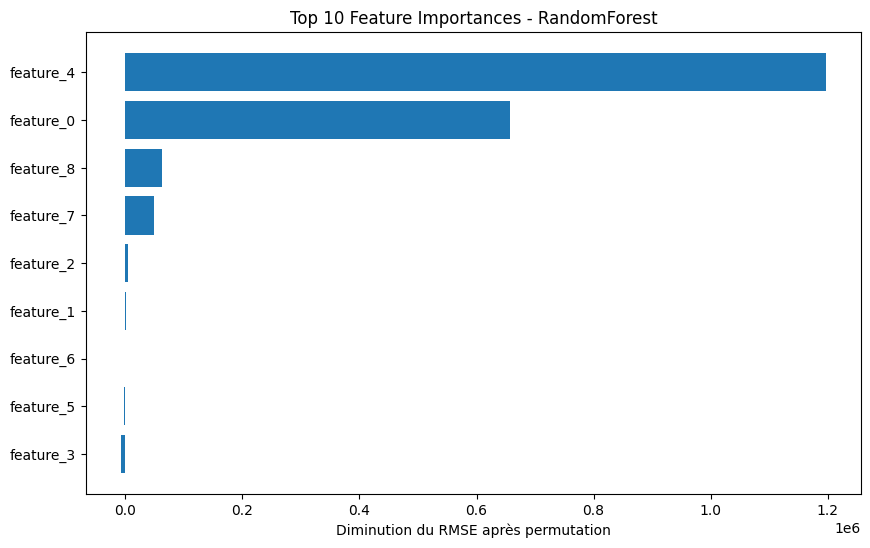

In [18]:
# Graphique
plt.figure(figsize=(10,6))
plt.barh(importances['feature'][:10][::-1], importances['importance_mean'][:10][::-1])
plt.xlabel("Diminution du RMSE après permutation")
plt.title("Top 10 Feature Importances - RandomForest")
plt.show()

In [121]:
cat_transformer = preprocess.named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(cat_cols)
print("Colonnes catégorielles transformées :")
print(cat_feature_names)

Colonnes catégorielles transformées :
['PrimaryPropertyType_Distribution Center' 'PrimaryPropertyType_Hotel'
 'PrimaryPropertyType_K-12 School' 'PrimaryPropertyType_Laboratory'
 'PrimaryPropertyType_Large Office'
 'PrimaryPropertyType_Low-Rise Multifamily'
 'PrimaryPropertyType_Medical Office'
 'PrimaryPropertyType_Mixed Use Property' 'PrimaryPropertyType_Office'
 'PrimaryPropertyType_Other' 'PrimaryPropertyType_Refrigerated Warehouse'
 'PrimaryPropertyType_Residence Hall' 'PrimaryPropertyType_Restaurant'
 'PrimaryPropertyType_Retail Store'
 'PrimaryPropertyType_Self-Storage Facility'
 'PrimaryPropertyType_Senior Care Community'
 'PrimaryPropertyType_Small- and Mid-Sized Office'
 'PrimaryPropertyType_Supermarket / Grocery Store'
 'PrimaryPropertyType_University' 'PrimaryPropertyType_Warehouse'
 'PrimaryPropertyType_Worship Facility' 'Neighborhood_BALLARD'
 'Neighborhood_Ballard' 'Neighborhood_CENTRAL' 'Neighborhood_Central'
 'Neighborhood_DELRIDGE' 'Neighborhood_DELRIDGE NEIGHBORHOODS'